In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile


zip_path = '/content/drive/MyDrive/DLA3_DATASET/DLA3_MNIST_Data.zip'


destination_path = '/content/MNIST_DATASET'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    zip_ref.extractall(destination_path)

print('Unzipping complete!')

Unzipping complete!


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
from torch import optim
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import recall_score

def get_one_hot_encoding(label, num_classes):
    onehot_encoded = np.zeros(num_classes)
    onehot_encoded[label] = 1
    return onehot_encoded


def one_hot_decoding(targets):
    return torch.argmax(targets, dim=1)


# Data Loader extended
class MNIST_DATASET(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
          Args:
          csv_file (string): Path to the csv file with
          labels.
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to
          be applied
          on a sample.
        """
        self.mnist_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # calculate mean and standard deviation for each channel of the dataset
        images = []
        for idx in range(len(self.mnist_frame)):
            img_name = os.path.join(self.root_dir, self.mnist_frame.iloc[idx, 0])
            image = io.imread(img_name)
            images.append(image)
        """
        The division by 255 is to normalize the pixel values of the images between 0 and 1, since the mean() and std() functions of PyTorch expect the data to be in that range.

        """
        images = torch.stack([torch.from_numpy(img) for img in images]).float() / 255
        self.mean = images.mean()
        self.std = images.std()

    def __len__(self):
        return len(self.mnist_frame)

    def __getitem__(self, idx):
        # Get image file name from specified index
        img_name = os.path.join(self.root_dir, self.mnist_frame.iloc[idx, 0])
        image = io.imread(img_name)
        # Read label for specified index and cast to int
        label = int(self.mnist_frame.iloc[idx, 1:])
        label = get_one_hot_encoding(label, 10)
        if self.transform:
            image = self.transform(image)
        normalize = transforms.Normalize(mean=self.mean, std=self.std)
        image_norm = normalize(image)
        return image, label


def Load_DataSet(Path_of_dataset, size_of_training_data, size_of_validation_data,
                 size_of_testing_data, batch_size):
    num_classes = 10
    # 1. Data loading and normalization
    train_data = MNIST_DATASET(csv_file='{}/dla3_train/train.csv'.format(Path_of_dataset),
                               root_dir='{}/dla3_train/train'.format(Path_of_dataset),
                               transform=transforms.ToTensor())
    if (size_of_training_data + size_of_validation_data) > train_data.__len__():
        print("size_of_training_data+size_of_validation_data is greater than training dataset length {}".format(
            train_data.__len__()))
    # Spliting data for trainging and validation
    train, val = random_split(train_data, [size_of_training_data, size_of_validation_data])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
    print("Training data loaded")
    # Load Test data
    test_data = MNIST_DATASET(csv_file='{}/dla3_test/test.csv'.format(Path_of_dataset),
                              root_dir='{}/dla3_test/test'.format(Path_of_dataset),
                              transform=transforms.ToTensor())
    if test_data.__len__() < size_of_testing_data:
        print("size_of_testing_datais greater than total test dataset {}".format(test_data.__len__()))
    testing_data, excluded = random_split(test_data, [size_of_testing_data, test_data.__len__() - size_of_testing_data])
    test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

    print("Data Loaded")

    return train_loader, val_loader, test_loader


def predict(outputs):
    max_values, predicted = torch.max(outputs.data, dim=1)
    return predicted


def save_model(model_name, model):
    # Save model
    torch.save(model.state_dict(), "{}.pth".format(model_name))


def load_model(model_name, model):
    if torch.cuda.is_available():
        device = torch.device('cuda')
        loaded_dict = torch.load("{}.pth".format(model_name))
    else:
        device = torch.device('cpu')
        loaded_dict = torch.load("{}.pth".format(model_name), map_location=torch.device('cpu'))

    # Load the learned parameters into the new model
    model.load_state_dict(loaded_dict)
    return model


class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, weights=None, bias=None, stride=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        if weights == None:
            # I have used xavier_uniform method to intitalize the weights , reason
            # is when i was trying to train my model my initial loss was very high
            # i tried to decrease the initial weight values and things improved but
            # not enough , i have faced the same issue in assignment 2 but in that
            # assignment multiplication with 0.01 did the trick and my loss reduced
            # During this assignment when i again faced the issue i searched for it
            # and tried xavier_uniform and this significantly improved the model
            # training performance
            self.weights = nn.init.xavier_uniform_(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
            # self.weights  = torch.randn(out_channels, in_channels, kernel_size, kernel_size)*0.001
            # Initialize the weight tensor with random values
            self.weight = nn.Parameter(self.weights)
        else:
            self.weight = nn.Parameter(weights)
        # Initialize the bias tensor with zeros
        self.bias = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        # Get input tensor dimensions
        batch_size, in_channels, in_height, in_width = x.shape

        # Compute output tensor dimensions
        out_height = in_height - self.kernel_size + 2 * self.padding + 1
        out_width = in_width - self.kernel_size + 2 * self.padding + 1

        # Initialize output tensor with zeros
        output_tensor = torch.zeros(batch_size, self.out_channels, out_height, out_width).to(x.device)

        # Adding padding on each side of the input (if provided , otherwise if 0 then this function will not add any padding)
        padded_tensor = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Reshape weight tensor
        weight_reshape = self.weight.view(self.out_channels, -1)

        # Loop over all windows and compute output tensor using matrix multiplication
        for i in range(out_height):
            for j in range(out_width):
                start_i = i * self.stride
                start_j = j * self.stride
                end_i = start_i + self.kernel_size
                end_j = start_j + self.kernel_size
                window = padded_tensor[:, :, start_i:end_i, start_j:end_j].reshape(batch_size, -1)

                output_tensor[:, :, i, j] = torch.mm(window, weight_reshape.t()) + self.bias

        return output_tensor


def MAX_POOL(feature_map, mode="max", filter_size=2, stride=2):
    # Extract dimensions from the feature map tensor
    batch_size, channels, height, width = feature_map.size()

    # Compute the output dimensions of the pooled feature map
    output_height = int((height - filter_size) / stride + 1)
    output_width = int((width - filter_size) / stride + 1)

    # Initialize a tensor to store the pooled feature map
    pooled = torch.zeros(batch_size, channels, output_height, output_width)

    # Loop over each element of the feature map and perform pooling
    for i in range(output_height):
        for j in range(output_width):
            # Extract the current pooling window from the feature map
            window = feature_map[:, :, i * stride:i * stride + filter_size, j * stride:j * stride + filter_size]

            # Apply max or average pooling
            if mode == "max":
                pooled[:, :, i, j] = torch.max(window.reshape(batch_size, channels, -1), dim=2)[0]
            else:
                raise ValueError("Only Max pooling mode supported not")

    return pooled


class CustomBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(CustomBlock, self).__init__()

        self.conv1 = Conv(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = Conv(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = MAX_POOL(out, mode="max", filter_size=2, stride=2)
        return out


class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Custom block replaces second block in VGG16
        self.block2 = CustomBlock(in_channels=64, out_channels=128)
        self.fc1 = nn.Linear(128 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        # Check if GPU available if yes then use it
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        x = x.to(device)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


def plot_tsne_first_last(test_loader, device):
    model1 = VGG16().to(device)
    model2 = VGG16().to(device)
    model_1 = load_model('first_epoch_model', model1)
    model_2 = load_model('mymodel', model2)

    dataset_y = []
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results1 = []
    tsne_results2 = []

    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)

        output1 = model_1(data).detach().cpu().numpy()
        output2 = model_2(data).detach().cpu().numpy()

        tsne_results1.append(output1)
        tsne_results2.append(output2)
        dataset_y.append(one_hot_decoding(labels))
    dataset_y = torch.cat(dataset_y, dim=0)
    tsne_results1 = np.concatenate(tsne_results1)

    tsne_results2 = np.concatenate(tsne_results2)

    tsne_results1 = tsne.fit_transform(tsne_results1)
    tsne_results2 = tsne.fit_transform(tsne_results2)
    # Plot t-SNE visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.scatter(tsne_results1[:, 0], tsne_results1[:, 1], c=dataset_y.detach().cpu().numpy(),
                cmap=plt.cm.get_cmap('jet', 10))
    ax1.set_title("t-SNE after 1st epoch")
    ax1.axis('off')
    ax2.scatter(tsne_results2[:, 0], tsne_results2[:, 1], c=dataset_y.detach().cpu().numpy(),
                cmap=plt.cm.get_cmap('jet', 10))
    ax2.set_title("t-SNE after training")
    ax2.axis('off')
    plt.show()


def train_model(train_loader, val_loader, total_epochs=50, lr=0.1, lr_decay_thresh=3, early_stop_thresh=3):
    # Check if GPU available if yes then use it
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Create model object and move its parameters to available device
    model = VGG16().to(device)
    # Set loss function to cross entropy
    Loss_func = nn.CrossEntropyLoss()
    # Select SGD optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_loss_list = []
    val_loss_list = []
    stop_count = 0
    val_stop_count = 0
    val_accuracy_list = []
    executed_epochs = 0
    dataset_x = []
    dataset_y = []
    for epoch in range(total_epochs):
        train_epoch_loss = 0.0
        executed_epochs += 1
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # labels_one_hot = F.one_hot(labels, num_classes=10)
            loss = Loss_func(outputs, torch.argmax(targets, dim=1))
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
        if (epoch == 1):
            save_model('first_epoch_model', model)
        # printing average loss of all the batches
        print("Epoch #{} Loss: {}".format(epoch, train_epoch_loss / len(train_loader)))
        train_loss_list.append(train_epoch_loss / len(train_loader))
        if len(train_loss_list) > 2:
            if train_loss_list[-1] >= train_loss_list[-2]:
                stop_count += 1
            else:
                stop_count = 0
            if stop_count == lr_decay_thresh:
                lr *= 0.1
                print("Learning Rate Updated to {}".format(lr))
            if stop_count == lr_decay_thresh + 3:
                stop_count = 0
                print("Early Stopping Applied")
                break
        # Evaluate model on validation set
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = Loss_func(outputs, torch.argmax(targets, dim=1))
                predicted = predict(outputs)

                total += targets.size(0)
                # Sum all the correct predictions in the batch
                correct_in_batch = (predicted == one_hot_decoding(targets)).sum().item()
                correct += correct_in_batch
                val_epoch_loss += loss.item()
            accuracy = 100 * correct / total
            val_accuracy_list.append(accuracy)
            print('Epoch #{} Test Accuracy: {}'.format(epoch, accuracy))
            print("Epoch #{} Validation Loss: {}".format(epoch, val_epoch_loss / len(val_loader)))
            val_loss_list.append(val_epoch_loss / len(val_loader))
            if len(val_loss_list) > 2:
                if val_loss_list[-1] > val_loss_list[-2]:
                    val_stop_count += 1
                else:
                    val_stop_count = 0
                if val_stop_count == early_stop_thresh:
                    print("Early Stopping Applied..")
                    break

        # Set model back to training mode
        model.train()

    return model, train_loss_list, val_loss_list, val_accuracy_list


def test_model(model, test_loader, device):
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predicted = predict(outputs)
            total += targets.size(0)
            correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

        accuracy = 100 * correct / total
        print('Test Accuracy: {}'.format(accuracy))


def plot_loss_acc(epochs, train_loss_list, val_loss_list, val_accuracy_list):
    t = np.arange(0, epochs)
    plt.plot(t, train_loss_list, label='Training Loss')
    plt.plot(t, val_loss_list, label='Validation Loss')
    plt.plot(t, val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Number of Epoches')
    plt.ylabel('Training Loss, Validation Loss and Accuracy')
    plt.legend()
    plt.show()


def calculate_f1score_confusion_matrix(test_ds_loader, model, device):
    predictions = []
    labels = []

    for img, lbl in test_ds_loader:
        # moving data to GPU
        img = img.to(device)
        lbl = lbl.to(device)

        output = model(img)
        pre = predict(output)
        lbl = torch.argmax(lbl, dim=1)
        predictions.extend(pre)
        labels.extend(lbl)

    return torch.tensor(predictions), torch.tensor(labels)


def plot_wrong_right_predictions(test_ds_loader, model, device):
    wrong_prediction = 0
    correct_prediction = 0
    model.eval()
    for img, lbl in test_ds_loader:
        # moving data to GPU
        img = img.to(device)
        lbl = lbl.to(device)

        output = model(img)
        pre = predict(output)
        lbl = torch.argmax(lbl, dim=1)
        # making cpu copy (basically changing tensor to numpy reason is that plt.imshow uses numpy array to plot although
        # it internally converts pytorch tensor to numpy but due to python version issues i am changing it my self so that
        # it does not give error on other version )
        cpu_copy = img.detach().cpu().numpy()
        i = 0
        if (correct_prediction < 4 or wrong_prediction < 4):
            while i < len(pre):
                if pre[i] == lbl[i]:
                    if (correct_prediction < 4):
                        print("************* <<Correct Prediction>> *************")
                        plt.figure()
                        plt.imshow(cpu_copy[i].reshape(28, 28))
                        plt.show()
                        print("Prediction was {}".format(pre[i]))
                        print("************* Correct Prediction *************")
                        correct_prediction += 1
                else:
                    if (wrong_prediction < 4):
                        print("************* <<Wrong Prediction>> *************")
                        plt.figure()
                        plt.imshow(cpu_copy[i].reshape(28, 28))
                        plt.show()
                        print("Prediction was {}".format(pre[i]))
                        print("************* Wrong Prediction *************")
                        wrong_prediction += 1
                i += 1


def calculate_f1_score(predicted, target):
    f1 = f1_score(target, predicted, average="weighted")
    print("F1 score:", f1)


def plot_confusion_matrix(Y, predicted_values):
    # 0 to 9 class labels
    class_labels = np.arange(10)

    # Calculate the confusion matrix
    cm = confusion_matrix(Y, predicted_values, labels=class_labels)
    # Create figure of size 10x10
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm)
    # Label axis
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_labels, yticklabels=class_labels,
           ylabel='Actual', xlabel='Predicted')
    plt.setp(ax.get_xticklabels(), ha="right")
    # Loop over cm matrix and actual values as text in the boxes.
    fmt = 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), color="white")

    fig.tight_layout()
    plt.show()


def recall_calculation(labels, predictions):
    return recall_score(labels, predictions, average='weighted')


def visualize_filters(model):
    # Get the state dictionary of the model
    state_dict = model.state_dict()
    num_filters = 128
    # Access the weights of the layer
    layer_name = 'block2.conv2.weight'
    layer_weights = state_dict[layer_name]
    # Extracted 128x3x3 (128 is number of filters)
    layer_weights = layer_weights[0, :, :, :].cpu().detach().numpy()
    # Create a grid of subplots to display the filters
    num_rows = 16
    num_cols = 8
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16))
    count = 0
    # Plot each filter
    for i in range(num_rows):
        for j in range(num_cols):
            axs[i, j].imshow(layer_weights[count], cmap='gray')
            count += 1
            axs[i, j].axis('off')

    # Display the plot
    plt.show()






Training data loaded
Data Loaded


<ipython-input-4-041a91409f3c>:67: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(self.mnist_frame.iloc[idx, 1:])


Epoch #0 Loss: 2.26381453871727
Epoch #0 Test Accuracy: 39.65
Epoch #0 Validation Loss: 1.9886745882034302
Epoch #1 Loss: 0.7548032933473587
Epoch #1 Test Accuracy: 86.38
Epoch #1 Validation Loss: 0.42946794579426445
Epoch #2 Loss: 0.3325387006253004
Epoch #2 Test Accuracy: 91.35
Epoch #2 Validation Loss: 0.2812921568999688
Epoch #3 Loss: 0.2364033591747284
Epoch #3 Test Accuracy: 93.89666666666666
Epoch #3 Validation Loss: 0.20730434142053128
Epoch #4 Loss: 0.17213709030300378
Epoch #4 Test Accuracy: 95.35
Epoch #4 Validation Loss: 0.15605869956314564
Epoch #5 Loss: 0.13703759390860795
Epoch #5 Test Accuracy: 96.09
Epoch #5 Validation Loss: 0.1302622260649999
Epoch #6 Loss: 0.11392471629505356
Epoch #6 Test Accuracy: 96.65333333333334
Epoch #6 Validation Loss: 0.1093249314216276
Epoch #7 Loss: 0.10062368983402849
Epoch #7 Test Accuracy: 97.06666666666666
Epoch #7 Validation Loss: 0.09676485719780127
Epoch #8 Loss: 0.09014338275417685
Epoch #8 Test Accuracy: 97.24333333333334
Epoch #8 

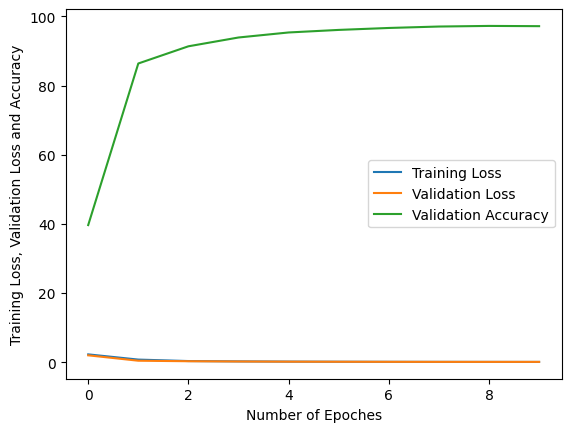

************* <<Correct Prediction>> *************


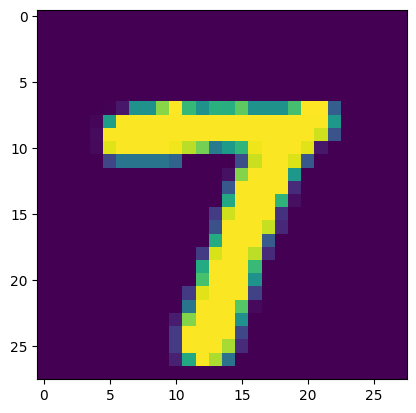

Prediction was 7
************* Correct Prediction *************
************* <<Correct Prediction>> *************


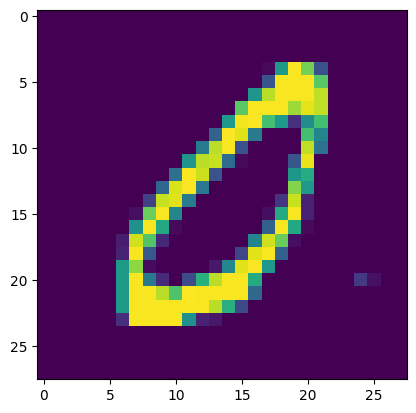

Prediction was 0
************* Correct Prediction *************
************* <<Correct Prediction>> *************


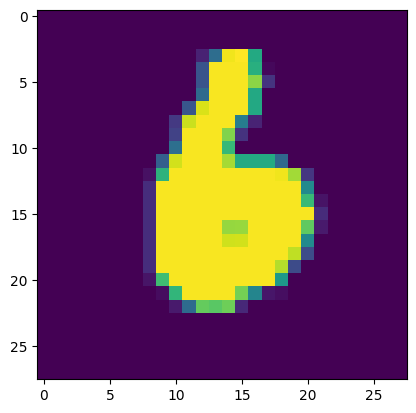

Prediction was 6
************* Correct Prediction *************
************* <<Correct Prediction>> *************


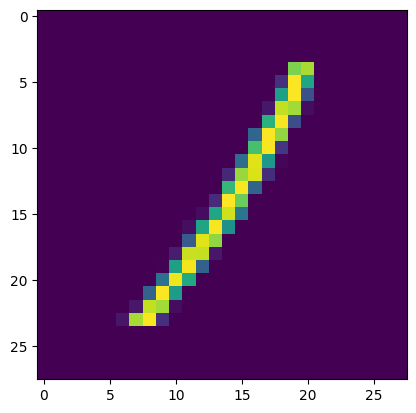

Prediction was 1
************* Correct Prediction *************
************* <<Wrong Prediction>> *************


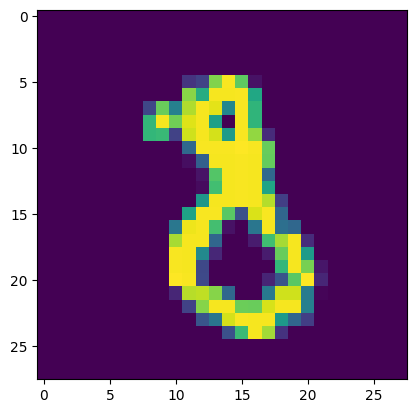

Prediction was 2
************* Wrong Prediction *************
************* <<Wrong Prediction>> *************


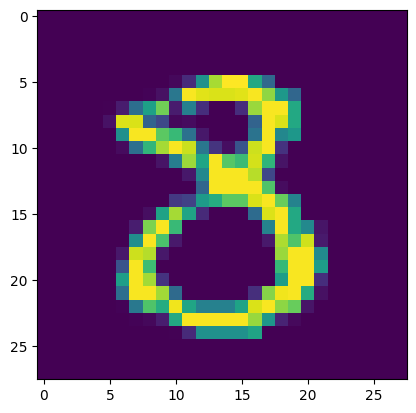

Prediction was 3
************* Wrong Prediction *************
************* <<Wrong Prediction>> *************


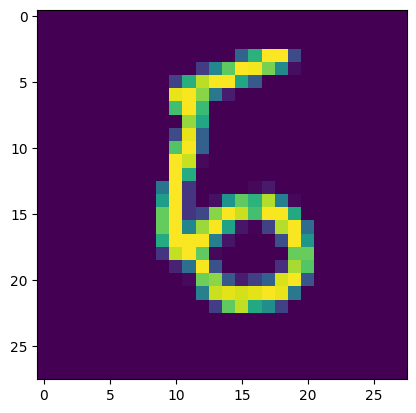

Prediction was 6
************* Wrong Prediction *************
************* <<Wrong Prediction>> *************


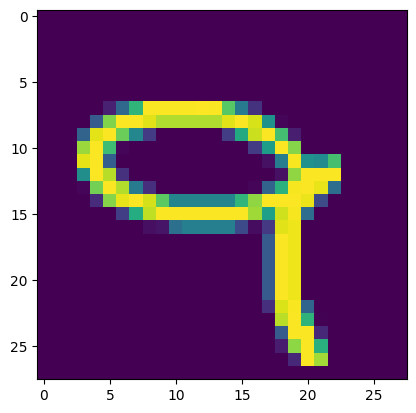

Prediction was 7
************* Wrong Prediction *************


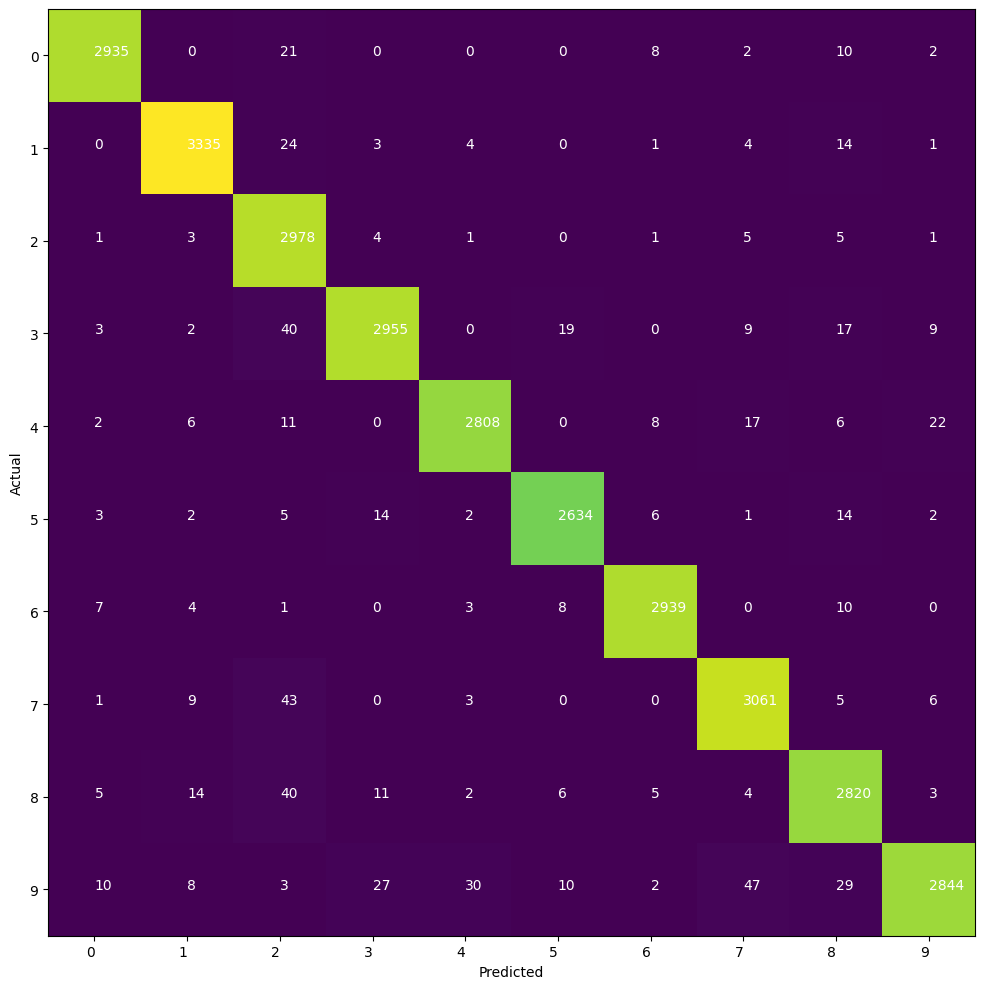

F1 score: 0.9769780248188387


<ipython-input-4-041a91409f3c>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load("{}.pth".format(model_name))
<ipython-input-4-041a91409f3c>:67: Fu

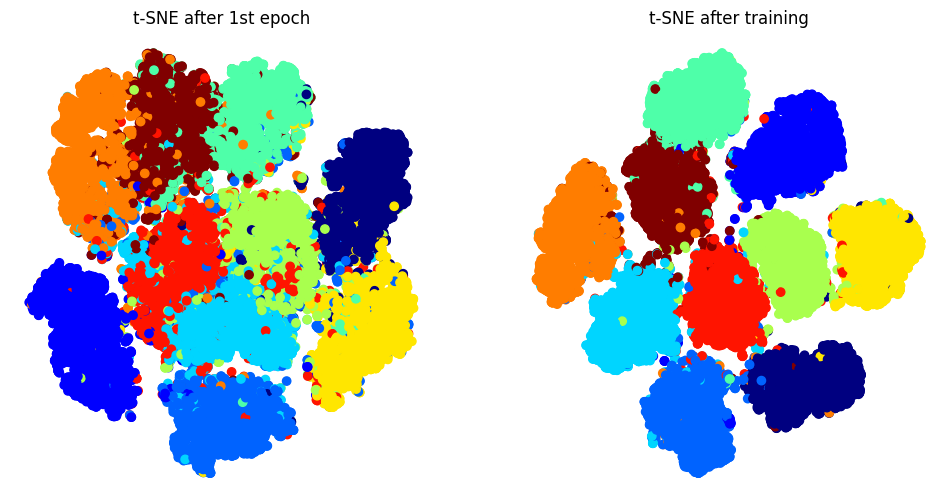

<ipython-input-4-041a91409f3c>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load("{}.pth".format(model_name))
<ipython-input-4-041a91409f3c>:67: Fu

Test Accuracy: 99.4


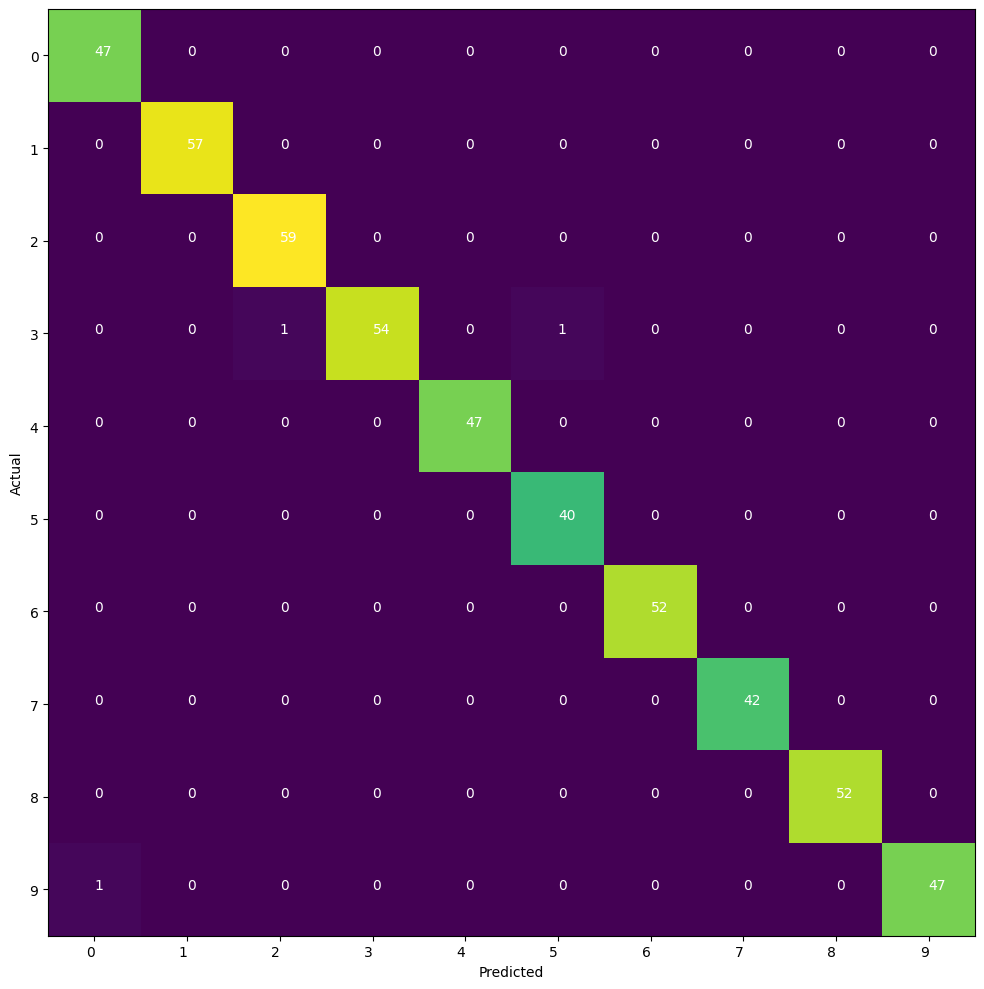

F1 score: 0.9939843854039934


<ipython-input-4-041a91409f3c>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load("{}.pth".format(model_name))
<ipython-input-4-041a91409f3c>:67: Fu

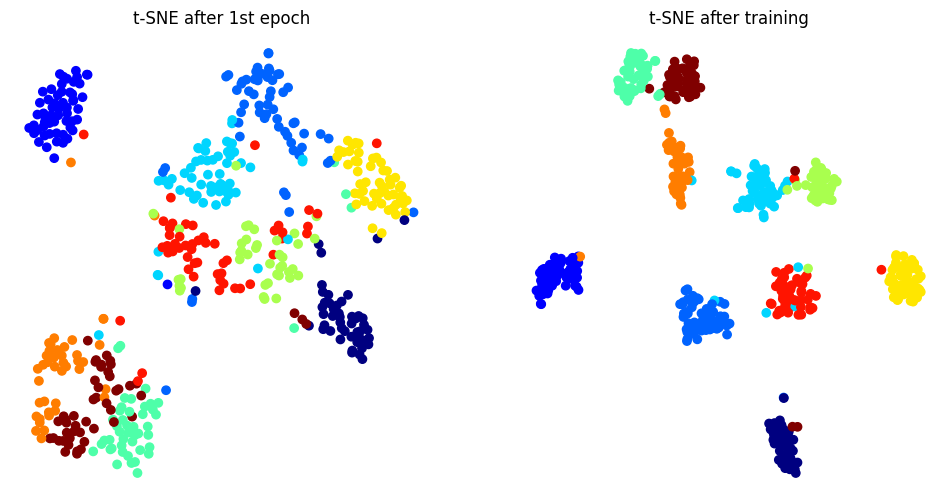

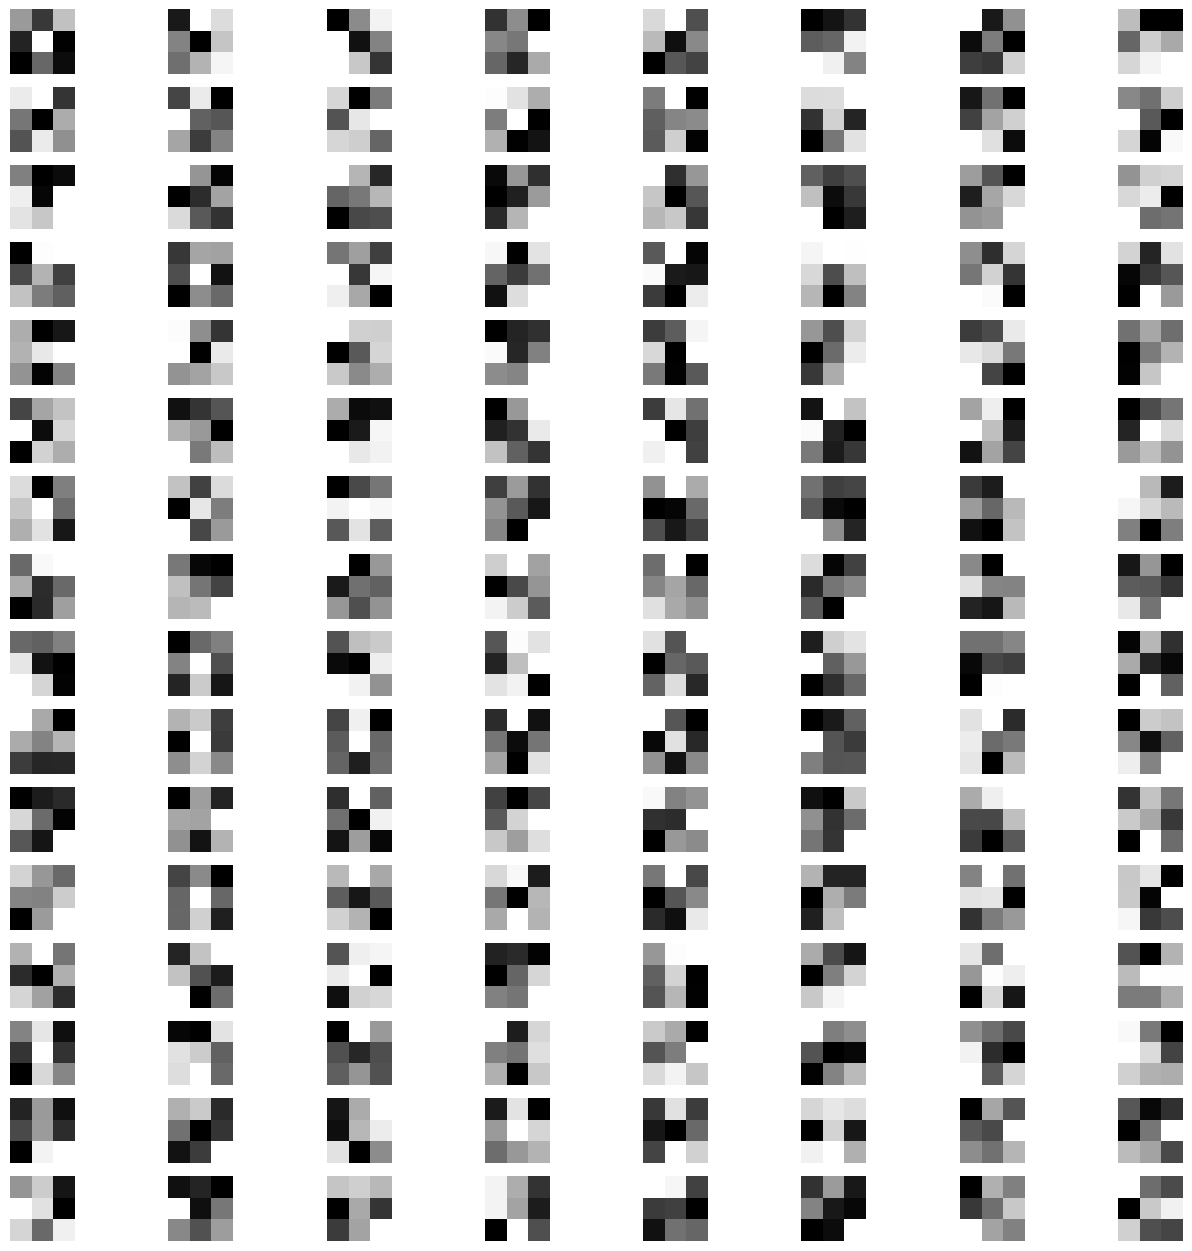

In [5]:
# Check if GPU available if yes then use it
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# Load Dataset
Path_of_dataset = r'/content/MNIST_DATASET/DLA3_MNIST_Data'
size_of_training_data = 30000
size_of_validation_data = 30000
size_of_testing_data = 500
batch_size = 100
training = True
testing = True
train_loader, val_loader, test_loader = Load_DataSet(Path_of_dataset, size_of_training_data,
                                                      size_of_validation_data,
                                                      size_of_testing_data, batch_size)
model = VGG16().to(device)
if training is True:
    model, train_loss_list, val_loss_list, val_accuracy_list = train_model(train_loader=train_loader,
                                                                            val_loader=val_loader, total_epochs=10,
                                                                            lr=0.01, lr_decay_thresh=3,
                                                                            early_stop_thresh=5)
    save_model('mymodel', model)
    # Plot loss,accuracy
    plot_loss_acc(len(train_loss_list), train_loss_list, val_loss_list, val_accuracy_list)

    # plot wrong/right predictions
    plot_wrong_right_predictions(train_loader, model, device)
    # Concatinating predictions and true values for complete dataset getting complete dataset predicted and true values
    predictions, labels = calculate_f1score_confusion_matrix(train_loader, model, device)
    # Plot confusion matrix
    plot_confusion_matrix(labels.numpy(), predictions.numpy())
    # Calculating f1 score for complete dataset
    calculate_f1_score(predictions.numpy(), labels.numpy())
    # Plot T-SNE after first epoch and for trained model
    plot_tsne_first_last(train_loader, device)
if testing is True:
    load_model('mymodel', model)
    test_model(model, test_loader, device)
    predictions, labels = calculate_f1score_confusion_matrix(test_loader, model, device)
    # Plot confusion matrix
    plot_confusion_matrix(labels.numpy(), predictions.numpy())
    # Calculating f1 score for complete dataset
    calculate_f1_score(predictions.numpy(), labels.numpy())
    # Plot T-SNE after first epoch and for trained model
    plot_tsne_first_last(test_loader, device)
    visualize_filters(model)


Mounted at /content/drive
